In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler
from sklearn.base import clone

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import seaborn as sns
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [21]:
train_path = 'C:/dev/zoomcamp/adult/adult.data'
test_path = 'C:/dev/zoomcamp/adult/adult.test'

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]


df_train = pd.read_csv(train_path, names=column_names, na_values=' ?', skipinitialspace=True)
df_test = pd.read_csv(test_path, names=column_names, na_values=' ?', skipinitialspace=True, skiprows=1)

df_train.drop(columns=['fnlwgt'], inplace=True)
df_test.drop(columns=['fnlwgt'], inplace=True)

df_test['income'] = df_test['income'].str.rstrip('.')

target_map = {"<=50K": 0, ">50K": 1}
df_train["income"] = df_train["income"].map(target_map)
df_test["income"] = df_test["income"].map(target_map)

In [22]:
def build_preprocessor(df_train):
    X = df_train.drop("income", axis=1)
    y = df_train["income"]

    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), num_cols),

            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols)
        ]
    )

    return X, y, preprocessor

In [23]:
X_train, y_train, preprocessor = build_preprocessor(df_train)
X_test = df_test.drop("income", axis=1)
y_test = df_test["income"]

In [24]:
def evaluate_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "recall": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=1),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
    }


In [25]:
def train_model(model, params, name, n_iter=50):
    print(f"\n===== {name} =====")

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])

    # build list of parameter samples
    param_list = list(ParameterSampler(params, n_iter=n_iter, random_state=42))

    best_score = -np.inf
    best_params = None
    best_estimator = None

    # iterate with tqdm progress bar
    for p in tqdm(param_list, desc=f"Randomized search [{name}]", unit="iter"):
        pipe.set_params(**p)

        # 5-fold stratified CV
        cv = StratifiedKFold(5, shuffle=True, random_state=42)
        fold_scores = []
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr_fold = X_train.iloc[train_idx]
            y_tr_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]

            pipe.fit(X_tr_fold, y_tr_fold)
            y_val_pred = pipe.predict(X_val_fold)
            fold_scores.append(f1_score(y_val_fold, y_val_pred))

        mean_score = np.mean(fold_scores)
        tqdm.write(f"params={ {k:v for k,v in p.items()} } -> f1={mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = p.copy()
            best_estimator = clone(pipe).set_params(**p)
            best_estimator.fit(X_train, y_train)

    # evaluate best on test set
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1]

    metrics = evaluate_metrics(y_test, y_pred, y_proba)
    print("Best Params:", best_params)
    print(metrics)

    return name, best_estimator, metrics


In [26]:
logreg_params = {
    "clf__C": np.logspace(-4, 4, 10),
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__class_weight": ["balanced"]
}

results = []
results.append(train_model(
    LogisticRegression(max_iter=2000),
    logreg_params,
    "Logistic Regression"
))


===== Logistic Regression =====


Randomized search [Logistic Regression]:   0%|          | 0/20 [00:09<?, ?iter/s]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.0001)} -> f1=0.6394


Randomized search [Logistic Regression]:   5%|▌         | 1/20 [00:13<03:04,  9.72s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.0001)} -> f1=0.6515


Randomized search [Logistic Regression]:  10%|█         | 2/20 [00:14<01:49,  6.09s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.000774263682681127)} -> f1=0.6585


Randomized search [Logistic Regression]:  15%|█▌        | 3/20 [00:15<01:05,  3.84s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.000774263682681127)} -> f1=0.6615


Randomized search [Logistic Regression]:  25%|██▌       | 5/20 [00:16<00:33,  2.25s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.005994842503189409)} -> f1=0.6748


Randomized search [Logistic Regression]:  30%|███       | 6/20 [00:18<00:27,  1.94s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.005994842503189409)} -> f1=0.6754


Randomized search [Logistic Regression]:  30%|███       | 6/20 [00:19<00:27,  1.94s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.046415888336127774)} -> f1=0.6810


Randomized search [Logistic Regression]:  35%|███▌      | 7/20 [00:21<00:23,  1.79s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.046415888336127774)} -> f1=0.6811


Randomized search [Logistic Regression]:  40%|████      | 8/20 [00:22<00:21,  1.75s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.3593813663804626)} -> f1=0.6815


Randomized search [Logistic Regression]:  45%|████▌     | 9/20 [00:24<00:19,  1.79s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.3593813663804626)} -> f1=0.6815


Randomized search [Logistic Regression]:  50%|█████     | 10/20 [00:27<00:17,  1.78s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(2.782559402207126)} -> f1=0.6816


Randomized search [Logistic Regression]:  55%|█████▌    | 11/20 [00:29<00:18,  2.06s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(2.782559402207126)} -> f1=0.6819


Randomized search [Logistic Regression]:  65%|██████▌   | 13/20 [00:32<00:16,  2.34s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(21.54434690031882)} -> f1=0.6814


Randomized search [Logistic Regression]:  70%|███████   | 14/20 [00:34<00:13,  2.23s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(21.54434690031882)} -> f1=0.6817


Randomized search [Logistic Regression]:  75%|███████▌  | 15/20 [00:38<00:13,  2.64s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(166.81005372000558)} -> f1=0.6813


Randomized search [Logistic Regression]:  80%|████████  | 16/20 [00:40<00:10,  2.51s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(166.81005372000558)} -> f1=0.6818


Randomized search [Logistic Regression]:  85%|████████▌ | 17/20 [00:46<00:10,  3.53s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(1291.5496650148827)} -> f1=0.6813


Randomized search [Logistic Regression]:  90%|█████████ | 18/20 [00:49<00:06,  3.33s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(1291.5496650148827)} -> f1=0.6817


Randomized search [Logistic Regression]:  95%|█████████▌| 19/20 [00:54<00:03,  3.97s/iter]

params={'clf__solver': 'liblinear', 'clf__class_weight': 'balanced', 'clf__C': np.float64(10000.0)} -> f1=0.6813


Randomized search [Logistic Regression]:  95%|█████████▌| 19/20 [00:57<00:03,  3.97s/iter]

params={'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(10000.0)} -> f1=0.6821


Randomized search [Logistic Regression]: 100%|██████████| 20/20 [00:57<00:00,  2.88s/iter]


Best Params: {'clf__solver': 'lbfgs', 'clf__class_weight': 'balanced', 'clf__C': np.float64(10000.0)}
{'accuracy': 0.808549843375714, 'precision': 0.5636903721824218, 'recall': 0.8387935517420697, 'f1': 0.6742606332950152, 'roc_auc': 0.9046276101144568, 'pr_auc': 0.7595086928179765}


In [27]:
dt_params = {
    "clf__max_depth": [3, 5, 10, 20, None],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__class_weight": ["balanced"]
}

results.append(train_model(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    "Decision Tree"
))


===== Decision Tree =====


Randomized search [Decision Tree]:   0%|          | 0/50 [00:02<?, ?iter/s]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 10, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6596


Randomized search [Decision Tree]:   4%|▍         | 2/50 [00:03<01:20,  1.67s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:   4%|▍         | 2/50 [00:04<01:20,  1.67s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6603


Randomized search [Decision Tree]:   8%|▊         | 4/50 [00:06<01:10,  1.54s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6596


Randomized search [Decision Tree]:  10%|█         | 5/50 [00:08<01:10,  1.56s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6603


Randomized search [Decision Tree]:  12%|█▏        | 6/50 [00:09<01:01,  1.40s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 10, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6596


Randomized search [Decision Tree]:  14%|█▍        | 7/50 [00:10<00:52,  1.22s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 5, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  16%|█▌        | 8/50 [00:16<01:58,  2.83s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6535


Randomized search [Decision Tree]:  18%|█▊        | 9/50 [00:17<01:30,  2.20s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  20%|██        | 10/50 [00:18<01:11,  1.79s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 10, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  20%|██        | 10/50 [00:23<01:11,  1.79s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6648


Randomized search [Decision Tree]:  22%|██▏       | 11/50 [00:27<02:06,  3.25s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6808


Randomized search [Decision Tree]:  26%|██▌       | 13/50 [00:33<02:30,  4.06s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6614


Randomized search [Decision Tree]:  28%|██▊       | 14/50 [00:36<02:08,  3.56s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6806


Randomized search [Decision Tree]:  30%|███       | 15/50 [00:43<02:40,  4.58s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6436


Randomized search [Decision Tree]:  32%|███▏      | 16/50 [00:45<02:15,  4.00s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 10, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6781


Randomized search [Decision Tree]:  34%|███▍      | 17/50 [00:51<02:32,  4.63s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 5, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6621


Randomized search [Decision Tree]:  36%|███▌      | 18/50 [00:56<02:28,  4.63s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 10, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6708


Randomized search [Decision Tree]:  38%|███▊      | 19/50 [01:01<02:26,  4.72s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6695


Randomized search [Decision Tree]:  40%|████      | 20/50 [01:04<02:04,  4.15s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6803


Randomized search [Decision Tree]:  42%|████▏     | 21/50 [01:05<01:32,  3.20s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 5, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  44%|████▍     | 22/50 [01:12<02:05,  4.48s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6285


Randomized search [Decision Tree]:  46%|████▌     | 23/50 [01:13<01:32,  3.42s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  48%|████▊     | 24/50 [01:16<01:21,  3.12s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6781


Randomized search [Decision Tree]:  48%|████▊     | 24/50 [01:18<01:21,  3.12s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6812


Randomized search [Decision Tree]:  52%|█████▏    | 26/50 [01:25<01:34,  3.95s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 10, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6708


Randomized search [Decision Tree]:  54%|█████▍    | 27/50 [01:28<01:26,  3.77s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 5, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6803


Randomized search [Decision Tree]:  56%|█████▌    | 28/50 [01:33<01:31,  4.15s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6633


Randomized search [Decision Tree]:  58%|█████▊    | 29/50 [01:34<01:09,  3.32s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6602


Randomized search [Decision Tree]:  60%|██████    | 30/50 [01:37<01:01,  3.06s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6809


Randomized search [Decision Tree]:  62%|██████▏   | 31/50 [01:43<01:13,  3.85s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6686


Randomized search [Decision Tree]:  64%|██████▍   | 32/50 [01:49<01:21,  4.51s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6701


Randomized search [Decision Tree]:  66%|██████▌   | 33/50 [01:49<00:57,  3.39s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 2, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  68%|██████▊   | 34/50 [01:54<01:01,  3.82s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6653


Randomized search [Decision Tree]:  70%|███████   | 35/50 [01:59<01:03,  4.22s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6609


Randomized search [Decision Tree]:  72%|███████▏  | 36/50 [02:01<00:45,  3.28s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6603


Randomized search [Decision Tree]:  74%|███████▍  | 37/50 [02:07<00:56,  4.32s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6489


Randomized search [Decision Tree]:  76%|███████▌  | 38/50 [02:09<00:40,  3.39s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 5, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6601


Randomized search [Decision Tree]:  78%|███████▊  | 39/50 [02:11<00:33,  3.05s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 10, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6781


Randomized search [Decision Tree]:  80%|████████  | 40/50 [02:12<00:23,  2.40s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 10, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  82%|████████▏ | 41/50 [02:16<00:27,  3.07s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 10, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6701


Randomized search [Decision Tree]:  84%|████████▍ | 42/50 [02:17<00:19,  2.38s/iter]

params={'clf__min_samples_split': 20, 'clf__min_samples_leaf': 1, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  86%|████████▌ | 43/50 [02:18<00:14,  2.01s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__class_weight': 'balanced'} -> f1=0.6603


Randomized search [Decision Tree]:  88%|████████▊ | 44/50 [02:21<00:12,  2.16s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6809


Randomized search [Decision Tree]:  90%|█████████ | 45/50 [02:21<00:08,  1.73s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  92%|█████████▏| 46/50 [02:28<00:12,  3.25s/iter]

params={'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6352


Randomized search [Decision Tree]:  94%|█████████▍| 47/50 [02:29<00:07,  2.51s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'} -> f1=0.6556


Randomized search [Decision Tree]:  96%|█████████▌| 48/50 [02:32<00:05,  2.60s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'} -> f1=0.6809


Randomized search [Decision Tree]:  98%|█████████▊| 49/50 [02:37<00:03,  3.44s/iter]

params={'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': None, 'clf__class_weight': 'balanced'} -> f1=0.6621


Randomized search [Decision Tree]: 100%|██████████| 50/50 [02:42<00:00,  3.25s/iter]

params={'clf__min_samples_split': 10, 'clf__min_samples_leaf': 5, 'clf__max_depth': 20, 'clf__class_weight': 'balanced'} -> f1=0.6686
Best Params: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}
{'accuracy': 0.802837663534181, 'precision': 0.5532306662202879, 'recall': 0.859334373374935, 'f1': 0.6731160896130346, 'roc_auc': 0.89934282292884, 'pr_auc': 0.7415856707936992}


In [28]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_params = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [0.8, 1],
    "clf__colsample_bytree": [0.8, 1],
    "clf__scale_pos_weight": [pos_weight]
}

results.append(train_model(
    XGBClassifier(eval_metric="logloss", random_state=42),
    xgb_params,
    "XGBoost"
))


===== XGBoost =====


Randomized search [XGBoost]:   0%|          | 0/50 [00:15<?, ?iter/s]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6805


Randomized search [XGBoost]:   2%|▏         | 1/50 [00:23<14:18, 17.51s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7150


Randomized search [XGBoost]:   4%|▍         | 2/50 [00:31<09:10, 11.47s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7172


Randomized search [XGBoost]:   8%|▊         | 4/50 [00:35<05:29,  7.16s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6597


Randomized search [XGBoost]:  10%|█         | 5/50 [00:40<04:39,  6.22s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7149


Randomized search [XGBoost]:  12%|█▏        | 6/50 [00:46<04:37,  6.30s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7103


Randomized search [XGBoost]:  14%|█▍        | 7/50 [00:58<05:49,  8.12s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.7091


Randomized search [XGBoost]:  16%|█▌        | 8/50 [01:06<05:33,  7.94s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7161


Randomized search [XGBoost]:  18%|█▊        | 9/50 [01:09<04:21,  6.37s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.6981


Randomized search [XGBoost]:  20%|██        | 10/50 [01:14<04:09,  6.23s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7161


Randomized search [XGBoost]:  22%|██▏       | 11/50 [01:25<04:59,  7.68s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.7049


Randomized search [XGBoost]:  22%|██▏       | 11/50 [01:32<04:59,  7.68s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7174


Randomized search [XGBoost]:  26%|██▌       | 13/50 [01:37<03:59,  6.47s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6932


Randomized search [XGBoost]:  28%|██▊       | 14/50 [01:42<03:36,  6.00s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6908


Randomized search [XGBoost]:  30%|███       | 15/50 [01:45<03:02,  5.20s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6796


Randomized search [XGBoost]:  32%|███▏      | 16/50 [01:51<03:10,  5.60s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7171


Randomized search [XGBoost]:  34%|███▍      | 17/50 [01:55<02:48,  5.09s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7170


Randomized search [XGBoost]:  36%|███▌      | 18/50 [01:57<02:15,  4.23s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.6981


Randomized search [XGBoost]:  36%|███▌      | 18/50 [02:00<02:15,  4.23s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7178


Randomized search [XGBoost]:  40%|████      | 20/50 [02:04<01:54,  3.81s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6763


Randomized search [XGBoost]:  42%|████▏     | 21/50 [02:10<02:08,  4.42s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7169


Randomized search [XGBoost]:  44%|████▍     | 22/50 [02:13<01:51,  3.97s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7145


Randomized search [XGBoost]:  46%|████▌     | 23/50 [02:19<02:01,  4.51s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7173


Randomized search [XGBoost]:  48%|████▊     | 24/50 [02:23<01:57,  4.53s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6922


Randomized search [XGBoost]:  50%|█████     | 25/50 [02:27<01:45,  4.23s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7169


Randomized search [XGBoost]:  52%|█████▏    | 26/50 [02:32<01:49,  4.57s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6959


Randomized search [XGBoost]:  54%|█████▍    | 27/50 [02:37<01:43,  4.50s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7154


Randomized search [XGBoost]:  56%|█████▌    | 28/50 [02:43<01:50,  5.03s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6956


Randomized search [XGBoost]:  58%|█████▊    | 29/50 [02:49<01:50,  5.24s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7152


Randomized search [XGBoost]:  60%|██████    | 30/50 [02:57<02:05,  6.29s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.7070


Randomized search [XGBoost]:  62%|██████▏   | 31/50 [03:02<01:50,  5.83s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7144


Randomized search [XGBoost]:  64%|██████▍   | 32/50 [03:06<01:36,  5.38s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7167


Randomized search [XGBoost]:  66%|██████▌   | 33/50 [03:13<01:37,  5.75s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7155


Randomized search [XGBoost]:  68%|██████▊   | 34/50 [03:15<01:14,  4.65s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7104


Randomized search [XGBoost]:  70%|███████   | 35/50 [03:19<01:06,  4.43s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6771


Randomized search [XGBoost]:  72%|███████▏  | 36/50 [03:22<00:54,  3.86s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.6986


Randomized search [XGBoost]:  74%|███████▍  | 37/50 [03:25<00:47,  3.66s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7152


Randomized search [XGBoost]:  76%|███████▌  | 38/50 [03:29<00:45,  3.76s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6765


Randomized search [XGBoost]:  78%|███████▊  | 39/50 [03:32<00:38,  3.52s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7134


Randomized search [XGBoost]:  80%|████████  | 40/50 [03:38<00:41,  4.18s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6773


Randomized search [XGBoost]:  82%|████████▏ | 41/50 [03:42<00:38,  4.29s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6954


Randomized search [XGBoost]:  84%|████████▍ | 42/50 [03:46<00:32,  4.06s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7149


Randomized search [XGBoost]:  86%|████████▌ | 43/50 [03:52<00:32,  4.68s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8} -> f1=0.6961


Randomized search [XGBoost]:  88%|████████▊ | 44/50 [03:56<00:26,  4.48s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6583


Randomized search [XGBoost]:  90%|█████████ | 45/50 [04:01<00:23,  4.73s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7152


Randomized search [XGBoost]:  92%|█████████▏| 46/50 [04:04<00:16,  4.06s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1} -> f1=0.7119


Randomized search [XGBoost]:  94%|█████████▍| 47/50 [04:10<00:14,  4.89s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1} -> f1=0.7147


Randomized search [XGBoost]:  96%|█████████▌| 48/50 [04:13<00:08,  4.27s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8} -> f1=0.7102


Randomized search [XGBoost]:  98%|█████████▊| 49/50 [04:16<00:03,  3.98s/iter]

params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8} -> f1=0.7152


Randomized search [XGBoost]: 100%|██████████| 50/50 [04:20<00:00,  5.20s/iter]


params={'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1} -> f1=0.6761
Best Params: {'clf__subsample': 1, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}
{'accuracy': 0.8342853633069222, 'precision': 0.6054759279676589, 'recall': 0.8567342693707748, 'f1': 0.7095176571920758, 'roc_auc': 0.9283728743600891, 'pr_auc': 0.827635072386864}


In [29]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

lgb_params = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__num_leaves": [15, 31, 63],
    "clf__subsample": [0.8, 1.0],
    "clf__class_weight": [None],
    "clf__scale_pos_weight": [pos_weight]
}

results.append(train_model(
    LGBMClassifier(
        objective="binary",
        random_state=42,
        verbosity=-1,
    ),
    lgb_params,
    "LightGBM"
))



===== LightGBM =====


Randomized search [LightGBM]:   0%|          | 0/36 [00:03<?, ?iter/s]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.6930


Randomized search [LightGBM]:   6%|▌         | 2/36 [00:07<01:56,  3.44s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.6930


Randomized search [LightGBM]:   6%|▌         | 2/36 [00:10<01:56,  3.44s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7036


Randomized search [LightGBM]:  11%|█         | 4/36 [00:15<02:03,  3.85s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7036


Randomized search [LightGBM]:  11%|█         | 4/36 [00:20<02:03,  3.85s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7107


Randomized search [LightGBM]:  17%|█▋        | 6/36 [00:25<02:16,  4.55s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7107


Randomized search [LightGBM]:  19%|█▉        | 7/36 [00:30<02:15,  4.66s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7025


Randomized search [LightGBM]:  22%|██▏       | 8/36 [00:34<02:08,  4.59s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7025


Randomized search [LightGBM]:  25%|██▌       | 9/36 [00:40<02:15,  5.02s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7104


Randomized search [LightGBM]:  28%|██▊       | 10/36 [00:47<02:20,  5.42s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7104


Randomized search [LightGBM]:  28%|██▊       | 10/36 [00:54<02:20,  5.42s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7142


Randomized search [LightGBM]:  33%|███▎      | 12/36 [01:04<02:48,  7.01s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.01, 'clf__class_weight': None} -> f1=0.7142


Randomized search [LightGBM]:  36%|███▌      | 13/36 [01:06<02:09,  5.61s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7137


Randomized search [LightGBM]:  39%|███▉      | 14/36 [01:09<01:42,  4.65s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7137


Randomized search [LightGBM]:  39%|███▉      | 14/36 [01:12<01:42,  4.65s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7164


Randomized search [LightGBM]:  44%|████▍     | 16/36 [01:15<01:17,  3.87s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7164


Randomized search [LightGBM]:  44%|████▍     | 16/36 [01:20<01:17,  3.87s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7166


Randomized search [LightGBM]:  50%|█████     | 18/36 [01:25<01:19,  4.44s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7166


Randomized search [LightGBM]:  53%|█████▎    | 19/36 [01:32<01:26,  5.11s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7153


Randomized search [LightGBM]:  56%|█████▌    | 20/36 [01:35<01:12,  4.55s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7153


Randomized search [LightGBM]:  56%|█████▌    | 20/36 [01:39<01:12,  4.55s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7168


Randomized search [LightGBM]:  61%|██████    | 22/36 [01:44<01:03,  4.51s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7168


Randomized search [LightGBM]:  61%|██████    | 22/36 [01:50<01:03,  4.51s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7169


Randomized search [LightGBM]:  67%|██████▋   | 24/36 [01:58<01:07,  5.61s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None} -> f1=0.7169


Randomized search [LightGBM]:  69%|██████▉   | 25/36 [02:00<00:50,  4.62s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7149


Randomized search [LightGBM]:  72%|███████▏  | 26/36 [02:02<00:39,  3.94s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7149


Randomized search [LightGBM]:  75%|███████▌  | 27/36 [02:05<00:32,  3.57s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7158


Randomized search [LightGBM]:  78%|███████▊  | 28/36 [02:08<00:26,  3.37s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7158


Randomized search [LightGBM]:  81%|████████  | 29/36 [02:12<00:24,  3.50s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7152


Randomized search [LightGBM]:  83%|████████▎ | 30/36 [02:15<00:21,  3.57s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7152


Randomized search [LightGBM]:  86%|████████▌ | 31/36 [02:19<00:17,  3.57s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7156


Randomized search [LightGBM]:  89%|████████▉ | 32/36 [02:22<00:14,  3.51s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7156


Randomized search [LightGBM]:  92%|█████████▏| 33/36 [02:28<00:12,  4.07s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7151


Randomized search [LightGBM]:  94%|█████████▍| 34/36 [02:32<00:08,  4.04s/iter]

params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 31, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7151


Randomized search [LightGBM]:  97%|█████████▋| 35/36 [02:38<00:04,  4.80s/iter]

params={'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7134


Randomized search [LightGBM]: 100%|██████████| 36/36 [02:45<00:00,  4.59s/iter]


params={'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.1, 'clf__class_weight': None} -> f1=0.7134
Best Params: {'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(3.152659099604642), 'clf__num_leaves': 63, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05, 'clf__class_weight': None}
{'accuracy': 0.8366807935630489, 'precision': 0.6131553860819828, 'recall': 0.8361934477379095, 'f1': 0.7075129248707513, 'roc_auc': 0.925494098171647, 'pr_auc': 0.822150568703969}


In [30]:
df_results = pd.DataFrame([
    {"model": name, **metrics}
    for (name, model, metrics) in results
])

df_results

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.808550,0.563690,0.838794,0.674261,0.904628,0.759509
1,Decision Tree,0.802838,0.553231,0.859334,0.673116,0.899343,0.741586
2,XGBoost,0.834285,0.605476,0.856734,0.709518,0.928373,0.827635
3,LightGBM,0.836681,0.613155,0.836193,0.707513,0.925494,0.822151


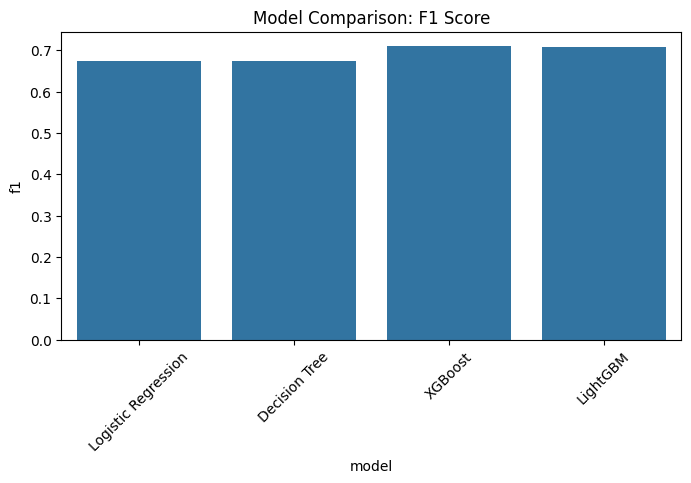

In [31]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x="model", y="f1")
plt.title("Model Comparison: F1 Score")
plt.xticks(rotation=45)
plt.show()

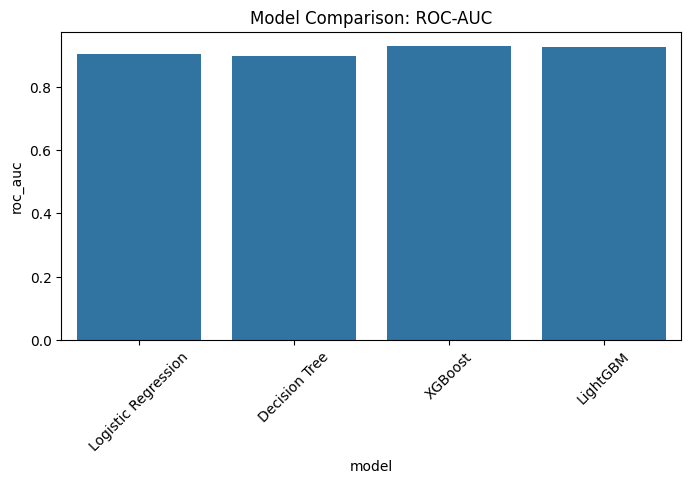

In [32]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x="model", y="roc_auc")
plt.title("Model Comparison: ROC-AUC")
plt.xticks(rotation=45)
plt.show()

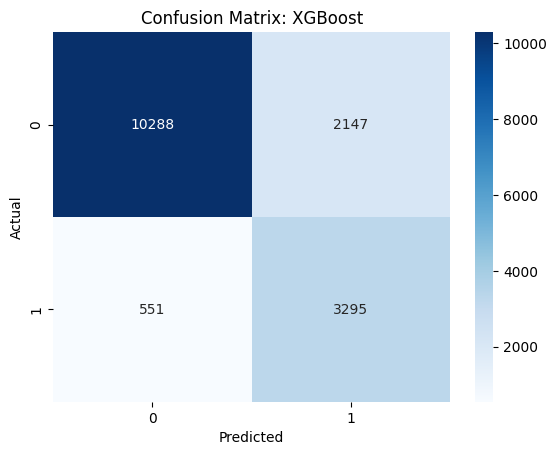

In [33]:
best_row = df_results.sort_values("f1", ascending=False).iloc[0]
best_name = best_row["model"]

best_model = [m for (name, m, metrics) in results if name == best_name][0]

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix: {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
